<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Assignment12/Session12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)
print (test_features.shape)

10
50000
(50000, 32, 32, 3)
(10000, 32, 32, 3)


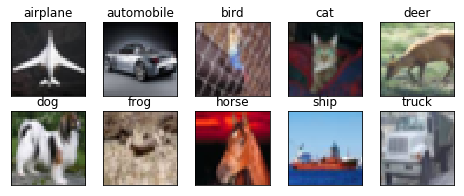

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
!git clone https://github.com/yu4u/cutout-random-erasing

fatal: destination path 'cutout-random-erasing' already exists and is not an empty directory.


In [28]:
#!cp cutout-random-erasing/* .
!ls

cifar10_resnet.py      example.ipynb  random_eraser.py
cutout-random-erasing  example.png    README.md
example2.png	       LICENSE	      sample_data


In [0]:
X_train = train_features
X_test = test_features
y_train = train_labels
y_test = test_labels

In [11]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))



W0722 14:39:39.684980 139719654909824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0722 14:39:39.700908 139719654909824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 14:39:39.703737 139719654909824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 14:39:39.732657 139719654909824 deprecation_wrapper.py

In [13]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
from random_eraser import get_random_eraser
datagen = ImageDataGenerator(horizontal_flip=True,
                             featurewise_center=True, featurewise_std_normalization=True,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

testgen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

In [30]:
!git clone https://github.com/titu1994/keras-one-cycle

Cloning into 'keras-one-cycle'...
remote: Enumerating objects: 208, done.
remote: Total 208 (delta 0), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (208/208), 3.18 MiB | 6.17 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [31]:
!cp keras-one-cycle/* .

cp: -r not specified; omitting directory 'keras-one-cycle/images'
cp: -r not specified; omitting directory 'keras-one-cycle/models'


In [15]:
from keras.optimizers import SGD
# Compile the model
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


W0722 14:41:07.299149 139719654909824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, validation_steps=100, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  if __name__ == '__main__':
W0722 14:42:06.560156 139719654909824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 16s 41ms/step - loss: 1.5184 - acc: 0.4698 - val_loss: 1.3664 - val_acc: 0.5316

Epoch 00001: val_acc improved from -inf to 0.53156, saving model to modelBest.h5
Epoch 2/100
390/390 [==============================] - 12s 31ms/step - loss: 1.1441 - acc: 0.6057 - val_loss: 1.1849 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.53156 to 0.60000, saving model to modelBest.h5
Epoch 3/100
390/390 [==============================] - 12s 30ms/step - loss: 1.0128 - acc: 0.6536 - val_loss: 1.2045 - val_acc: 0.6119

Epoch 00003: val_acc improved from 0.60000 to 0.61187, saving model to modelBest.h5
Epoch 4/100
390/390 [==============================] - 12s 30ms/step - loss: 0.9302 - acc: 0.6855 - val_loss: 0.9387 - val_acc: 0.6938

Epoch 00004: val_acc improved from 0.61187 to 0.69378, saving model to modelBest.h5
Epoch 5/100
390/390 [==============================] - 12s 31ms/step - loss: 0.8638 - acc: 0.7113 - val_loss: 0.9083 - val_acc: 0.6994


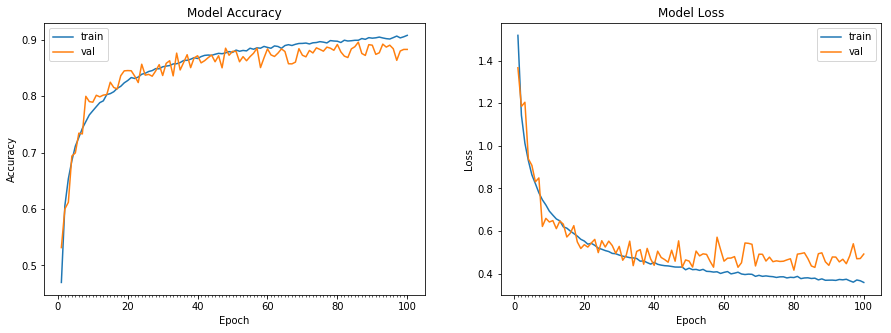

NameError: ignored

In [17]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('modelBest.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto') 
# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = testgen.flow(X_test, y_test), verbose=1,validation_steps=100,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, y_test, model1))

## Max training and test accuracy

In [18]:
print("Training Accuracy:")
print(max(model_info.history['acc']))
print("Test Accuracy:")
print(max(model_info.history['val_acc']))

Training Accuracy:
0.9077438242281711
Test Accuracy:
0.895625


In [0]:
from keras.models import load_model
modelBest = load_model("modelBest.h5")

##Model Evaluate for best model

In [21]:
modelBest.evaluate_generator(testgen.flow(X_test, y_test), steps=32)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[0.4871593019925058, 0.876953125]

In [22]:
test_generator = testgen.flow(X_test, y_test,
  shuffle=False)
y_pred = modelBest.predict_generator(test_generator, steps=100)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
